## limpieza

In [ ]:
# Import the necessary libraries and functions
# #pip install pandas, scikit-learn#, matplotlib, seaborn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#pip install fastparquet

# Leer el archivo Parquet
df = pd.read_parquet(r"D:\MAESTRIA DATA SCIENCE\semestre3\misti\clase04\DB_ML.parquet", engine="fastparquet")


In [6]:
df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Fecha                                        5 non-null      datetime64[ns]
 1   POTENCIA _ kW                                5 non-null      float64       
 2    PRESION ALIMENTADORES SAG_ KPa              5 non-null      float64       
 3   PRESION DESCARGAS SAG_ Kpa                   5 non-null      float64       
 4   PESO TOTAL SAG_ ton                          5 non-null      float64       
 5   CORRIENTE ESTATOR SAG_ Amp                   5 non-null      float64       
 6   SOLIDOS SAG_ %                               5 non-null      float64       
 7   TORQUE SAG                                   5 non-null      float64       
 8   TPH fresco SAG                               5 non-null      float64       
 9   RPM

Total de variables numéricas: 41
Variables: ['POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa', 'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton', 'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG', 'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG', 'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\\min', 'Impactos estándar SAG_ imp\\min', 'Flujo de agua al SAG_ m3\\h', 'Flujo de agua en descarga SAG_ m3\\h', 'Flujo de agua en zaranda descarga SAG_ m3\\h', 'Flujo de agua en cajón BM_ m3\\h', 'CEE SAG ', 'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO', 'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\\Size)', 'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\\Size)', 'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5', 'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5', 'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile', '% V Feeder 4', '% V Feeder 5', '% V Feeder 6', '% V Feeder 7']



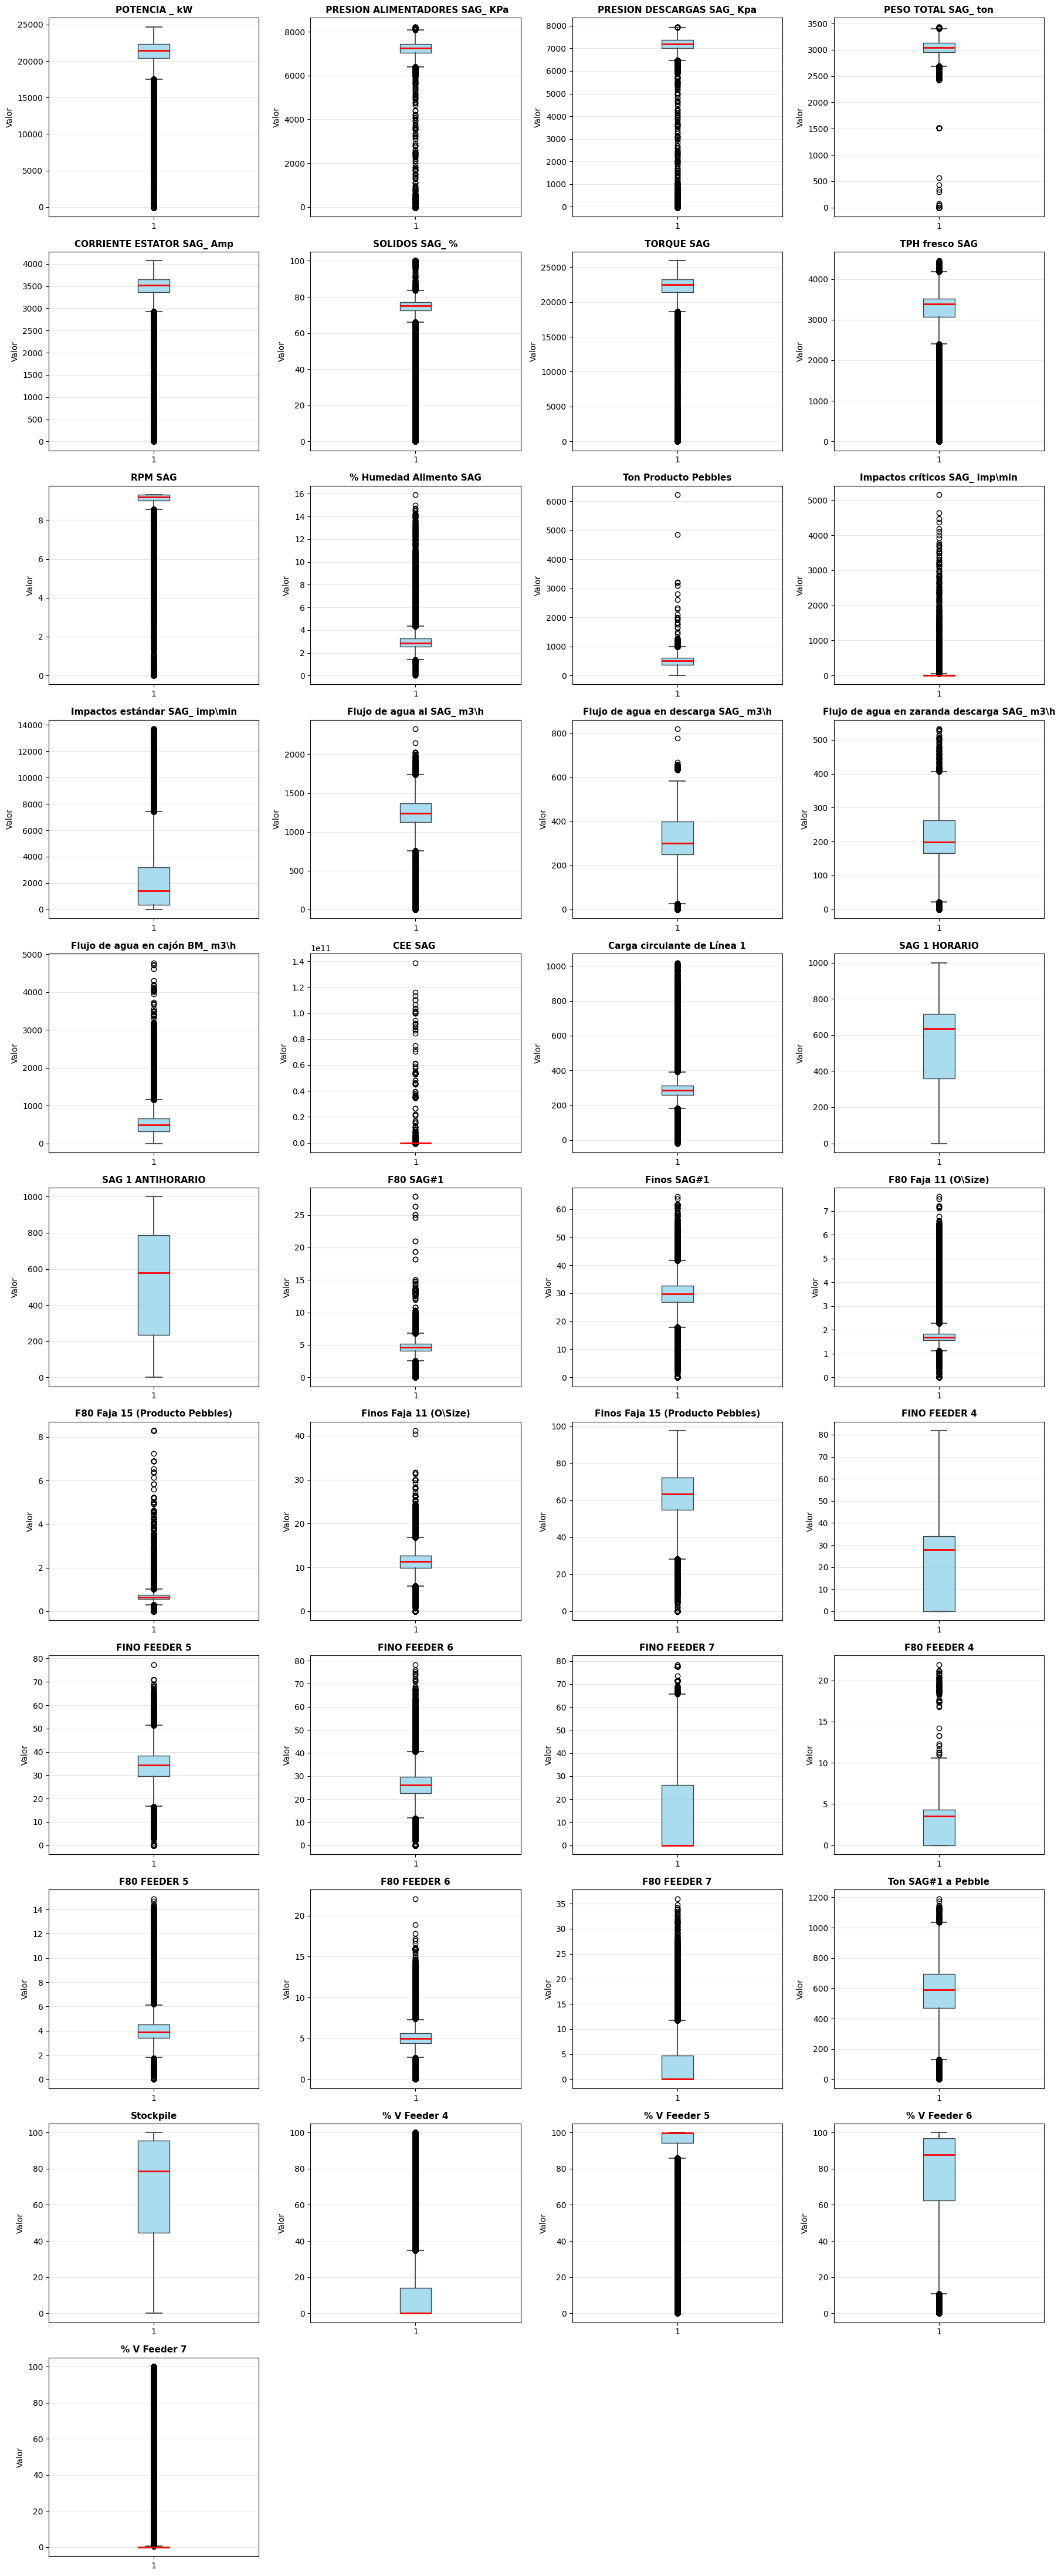


Estadísticas resumidas por variable:
                                                count          mean  \
POTENCIA _ kW                                551068.0  1.978971e+04   
 PRESION ALIMENTADORES SAG_ KPa              555576.0  7.099431e+03   
PRESION DESCARGAS SAG_ Kpa                   555576.0  7.049731e+03   
PESO TOTAL SAG_ ton                          551069.0  3.030193e+03   
CORRIENTE ESTATOR SAG_ Amp                   550982.0  3.249433e+03   
SOLIDOS SAG_ %                               555577.0  7.260242e+01   
TORQUE SAG                                   529468.0  2.066462e+04   
TPH fresco SAG                               571254.0  2.960012e+03   
RPM SAG                                      551068.0  8.419743e+00   
% Humedad Alimento SAG                       506427.0  2.980420e+00   
Ton Producto Pebbles                         570990.0  4.594942e+02   
Impactos críticos SAG_ imp\min               551596.0  1.503796e+01   
Impactos estándar SAG_ imp\min         

In [7]:
# Boxplots para todas las variables numéricas (excepto fecha)

# Obtener columnas numéricas (excluyendo datetime)
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total de variables numéricas: {len(columnas_numericas)}")
print(f"Variables: {columnas_numericas}\n")

# Crear subplots
n_cols = 4  # 4 gráficos por fila
n_rows = (len(columnas_numericas) + n_cols - 1) // n_cols  # Calcular filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()  # Convertir a array 1D

# Crear un boxplot para cada columna numérica
for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    # Boxplot
    bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
    
    # Estilo
    for patch in bp['boxes']:
        patch.set_facecolor('#87CEEB')
        patch.set_alpha(0.7)
    
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, color='#555')
    
    for cap in bp['caps']:
        cap.set(linewidth=1.5, color='#555')
    
    for median in bp['medians']:
        median.set(linewidth=2, color='red')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Eliminar subplots vacíos
for idx in range(len(columnas_numericas), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Estadísticas resumidas por variable:")
print("="*70)
print(df[columnas_numericas].describe().T)

In [6]:
x = list(df.columns)
df.columns

Index(['Fecha', 'POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa',
       'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton',
       'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG',
       'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG',
       'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\min',
       'Impactos estándar SAG_ imp\min', 'Flujo de agua al SAG_ m3\h',
       'Flujo de agua en descarga SAG_ m3\h',
       'Flujo de agua en zaranda descarga SAG_ m3\h',
       'Flujo de agua en cajón BM_ m3\h', 'CEE SAG ',
       'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO',
       'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\Size)',
       'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\Size)',
       'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5',
       'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5',
       'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile',
       '% V Feeder 4', '%

In [7]:
columnas_TPH = [col for col in df.columns if "POT" in col]
columnas_TPH

['POTENCIA _ kW']

In [8]:
# Filtrar registros dentro del rango intercuartil para variables TPH

# Obtener las columnas que contienen "TPH"
columnas_TPH = [col for col in df.columns if "TPH" in col]

print(f"Columnas con 'TPH': {columnas_TPH}")
print("\n" + "="*70)

# Crear máscara para mantener solo registros dentro del IQR para TODAS las columnas TPH
mask_dentro = pd.Series([True] * len(df), index=df.index)

for col in columnas_TPH:
    # Calcular Q1, Q3 e IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_en_col = ((df[col] < limite_inferior) | (df[col] > limite_superior)).sum()
    
    print(f"\n📊 {col}:")
    print(f"   - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"   - Rango válido: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"   - Outliers: {outliers_en_col}")
    
    # Actualizar máscara
    mask_dentro = mask_dentro & ((df[col] >= limite_inferior) & (df[col] <= limite_superior))

# Aplicar filtro
df_filtrado_tph = df[mask_dentro].copy()

print("\n" + "="*70)
print("RESUMEN DE FILTRADO:")
print("="*70)
print(f"Filas originales:     {len(df)}")
print(f"Filas después filtro: {len(df_filtrado_tph)}")
print(f"Filas removidas:      {len(df) - len(df_filtrado_tph)} ({(len(df) - len(df_filtrado_tph))/len(df)*100:.2f}%)")
print("="*70)

Columnas con 'TPH': ['TPH fresco SAG']


📊 TPH fresco SAG:
   - Q1: 3069.11, Q3: 3516.96, IQR: 447.85
   - Rango válido: [2397.33, 4188.73]
   - Outliers: 80157

RESUMEN DE FILTRADO:
Filas originales:     571320
Filas después filtro: 491097
Filas removidas:      80223 (14.04%)


In [9]:
df_filtrado_pot = df_filtrado_tph.copy()

In [10]:
# Limpieza de 'POTENCIA _ kW' por Rango Intercuartil en df_filtrado_pot

columna_potencia = 'POTENCIA _ kW'

# Verificar que la columna existe
if columna_potencia in df_filtrado_pot.columns:
    print(f"Limpiando columna: {columna_potencia}")
    print("=" * 70)
    
    # Calcular estadísticos
    Q1 = df_filtrado_pot[columna_potencia].quantile(0.25)
    Q3 = df_filtrado_pot[columna_potencia].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites (factor de Tukey = 1.5)
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers_mask = (df_filtrado_pot[columna_potencia] < limite_inferior) | (df_filtrado_pot[columna_potencia] > limite_superior)
    num_outliers = outliers_mask.sum()
    
    # Mostrar información detallada
    print(f"\n📊 Estadísticos de {columna_potencia}:")
    print(f"   - Mínimo:           {df_filtrado_pot[columna_potencia].min():.4f}")
    print(f"   - Q1 (25%):         {Q1:.4f}")
    print(f"   - Mediana (50%):    {df_filtrado_pot[columna_potencia].median():.4f}")
    print(f"   - Q3 (75%):         {Q3:.4f}")
    print(f"   - Máximo:           {df_filtrado_pot[columna_potencia].max():.4f}")
    print(f"   - IQR:              {IQR:.4f}")
    
    print(f"\n🎯 Límites del Rango Intercuartil (1.5×IQR):")
    print(f"   - Límite inferior:  {limite_inferior:.4f}")
    print(f"   - Límite superior:  {limite_superior:.4f}")
    
    print(f"\n⚠️  Outliers detectados: {num_outliers} ({num_outliers/len(df_filtrado_pot)*100:.2f}%)")
    
    # Mostrar ejemplos de valores removidos
    if num_outliers > 0:
        outliers_valores = df_filtrado_pot[outliers_mask][columna_potencia].sort_values()
        print(f"\n🔍 Valores de outliers a remover:")
        print(f"   - Valores bajos (< {limite_inferior:.4f}): {(outliers_valores < limite_inferior).sum()}")
        print(f"   - Valores altos (> {limite_superior:.4f}): {(outliers_valores > limite_superior).sum()}")
        print(f"   - Rango de outliers: [{outliers_valores.min():.4f}, {outliers_valores.max():.4f}]")
    
    # Limpiar el dataframe
    df_filtrado_pot = df_filtrado_pot[~outliers_mask].copy()
    
    print(f"\n📈 Resumen de limpieza:")
    print(f"   - Filas originales:     {len(df_filtrado_pot) + num_outliers}")
    print(f"   - Filas después:        {len(df_filtrado_pot)}")
    print(f"   - Filas removidas:      {num_outliers} ( {num_outliers/len(df_filtrado_pot)*100:.2f}%)")
    print("\n" + "=" * 70)
    print("✓ Limpieza completada. df_filtrado_pot actualizado.")
else:
    print(f"❌ Error: La columna '{columna_potencia}' no existe en el dataframe")
    print(f"Columnas disponibles: {list(df_filtrado_pot.columns)}")

Limpiando columna: POTENCIA _ kW

📊 Estadísticos de POTENCIA _ kW:
   - Mínimo:           -44.1233
   - Q1 (25%):         20730.2954
   - Mediana (50%):    21607.8503
   - Q3 (75%):         22424.5027
   - Máximo:           24685.3235
   - IQR:              1694.2073

🎯 Límites del Rango Intercuartil (1.5×IQR):
   - Límite inferior:  18188.9844
   - Límite superior:  24965.8137

⚠️  Outliers detectados: 6233 (1.27%)

🔍 Valores de outliers a remover:
   - Valores bajos (< 18188.9844): 6233
   - Valores altos (> 24965.8137): 0
   - Rango de outliers: [-44.1233, 18188.9728]

📈 Resumen de limpieza:
   - Filas originales:     491097
   - Filas después:        484864
   - Filas removidas:      6233 ( 1.29%)

✓ Limpieza completada. df_filtrado_pot actualizado.


In [11]:
df_filtrado_pot.describe()

,Fecha,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,...,F80 FEEDER 4,F80 FEEDER 5,F80 FEEDER 6,F80 FEEDER 7,Ton SAG#1 a Pebble,Stockpile,% V Feeder 4,% V Feeder 5,% V Feeder 6,% V Feeder 7
count,345022,484805.000000,484838.000000,484838.000000,484805.000000,480941.000000,484838.000000,463953.000000,484864.000000,484805.000000,...,484517.000000,483933.000000,484862.000000,484511.000000,484860.000000,484844.000000,484862.000000,484862.000000,484862.000000,484862.000000
mean,2019-09-01 17:23:53.018184448,21553.701702,7260.966838,7215.417913,3049.271879,3526.088888,74.831653,22486.871435,3379.383987,9.154453,...,2.911422,4.026320,5.055390,2.727719,613.994416,71.976726,12.117566,96.654461,83.613142,3.911763
min,2019-03-01 07:00:00,18189.047673,0.000000,0.000000,2638.242407,2687.086182,59.987210,18673.451839,2397.366172,7.249231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-06-02 14:49:15,20770.450563,7069.819458,7055.572142,2967.420239,3409.736802,72.996272,21747.785352,3263.793183,9.069560,...,0.000000,3.500000,4.500000,0.000000,528.800000,53.100000,0.100000,99.700000,78.000000,0.000000
50%,2019-09-04 11:18:30,21628.005664,7288.898741,7230.905807,3059.936934,3539.802686,75.271968,22599.683903,3432.980022,9.239951,...,3.600000,3.900000,5.000000,0.000000,616.700000,80.500000,3.900000,99.800000,91.200000,0.100000
75%,2019-11-13 22:30:45,22435.101449,7461.660334,7377.574442,3133.981539,3659.208496,76.995440,23336.598177,3538.754346,9.299621,...,4.400000,4.500000,5.600000,5.100000,710.600000,95.300000,16.100000,99.800000,97.900000,2.000000
max,2020-03-31 23:59:00,24685.323454,8201.756535,7940.068608,3429.996419,4050.138672,100.000000,25674.577067,4188.728849,9.304526,...,14.200000,14.700000,22.100000,36.000000,1176.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,1184.141633,289.727745,248.092711,120.493541,187.213200,2.629172,1171.132546,268.587881,0.193136,...,2.072678,0.963642,1.076215,3.434975,142.428436,26.179968,19.176044,9.588099,20.768961,9.738112


Columnas TPH encontradas: ['TPH fresco SAG']

Datos para últimos 30 días:
  Fecha inicio: 2020-01-31 23:59:00
  Fecha fin:    2020-03-31 23:59:00
  Total registros: 62492
  Graficando: ['TPH fresco SAG']


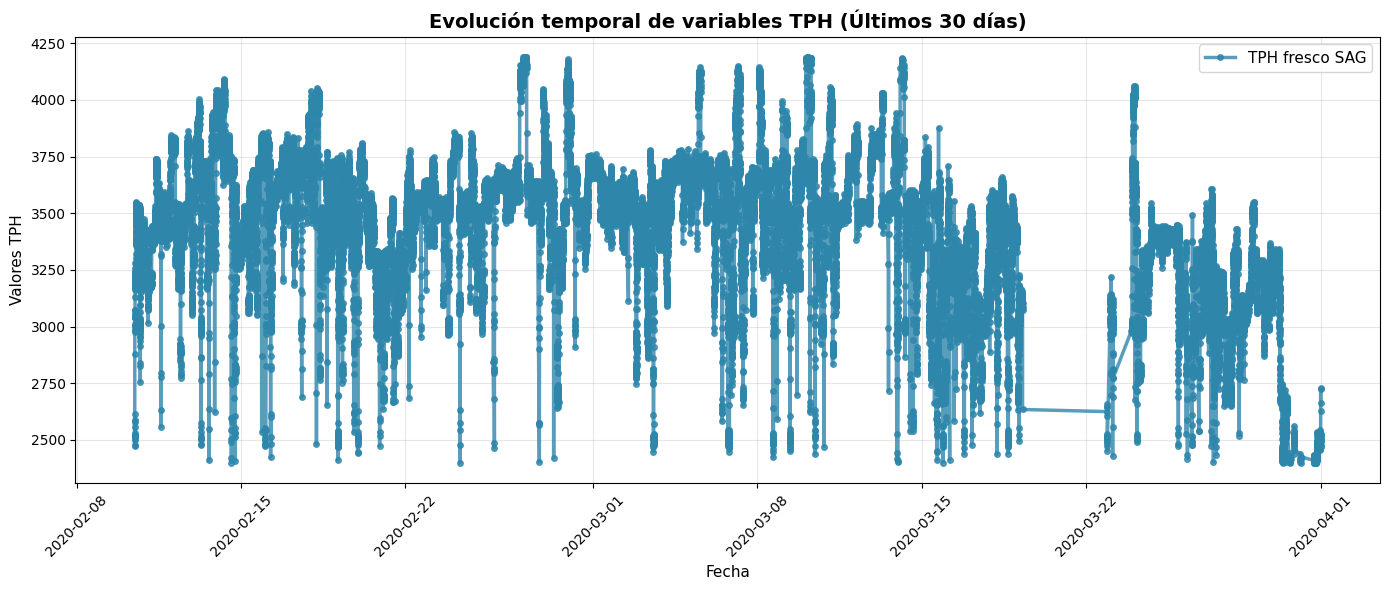


ESTADÍSTICAS DE VARIABLES TPH (últimos 30 días)
                  count         mean         std         min          25%  \
TPH fresco SAG  62492.0  3445.896509  293.182409  2397.58232  3293.259017   

                        50%          75%          max  
TPH fresco SAG  3497.696223  3644.914606  4188.728849  


In [12]:
# Gráfica Time Series: Fecha vs TPH (solo últimos 30 días)

# Identificar la columna de fecha
fecha_col = fecha_columns[0] if fecha_columns else None

# Obtener columnas con TPH
columnas_tph = [col for col in df_filtrado_pot.columns if "TPH" in col]

print(f"Columnas TPH encontradas: {columnas_tph}")

if fecha_col and columnas_tph:
    # Ordenar por fecha y filtrar últimos 30 días
    df_plot = df_filtrado_pot.sort_values(by=fecha_col).copy()
    
    # Calcular fecha máxima y restar 30 días
    fecha_max = df_plot[fecha_col].max()
    fecha_min = fecha_max - pd.Timedelta(days=60)
    
    # Filtrar datos de últimos 30 días
    df_plot = df_plot[(df_plot[fecha_col] >= fecha_min) & (df_plot[fecha_col] <= fecha_max)]
    
    print(f"\nDatos para últimos 30 días:")
    print(f"  Fecha inicio: {fecha_min}")
    print(f"  Fecha fin:    {fecha_max}")
    print(f"  Total registros: {len(df_plot)}")
    
    # Usar solo las dos primeras columnas TPH
    columnas_a_graficar = columnas_tph[:2] if len(columnas_tph) >= 2 else columnas_tph
    print(f"  Graficando: {columnas_a_graficar}")
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Colores para cada línea
    colores = ['#2E86AB', '#A23B72']
    
    # Plotear columnas TPH
    for idx, col_tph in enumerate(columnas_a_graficar):
        color = colores[idx]
        ax.plot(df_plot[fecha_col], df_plot[col_tph], 
                linewidth=2.5, color=color, alpha=0.8, marker='o', markersize=4, label=col_tph)
    
    # Estilo
    ax.set_title('Evolución temporal de variables TPH (Últimos 30 días)', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{fecha_col}', fontsize=11)
    ax.set_ylabel('Valores TPH', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=11)
    
    # Rotar etiquetas del eje X
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("ESTADÍSTICAS DE VARIABLES TPH (últimos 30 días)")
    print("=" * 70)
    print(df_plot[columnas_a_graficar].describe().T)
else:
    print("❌ Error: No se encontró columna de fecha o columnas TPH")
    print(f"Fecha: {fecha_col}")
    print(f"TPH: {columnas_tph}")

In [34]:
df_filtrado_pot.describe()

,Fecha,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,...,F80 FEEDER 4,F80 FEEDER 5,F80 FEEDER 6,F80 FEEDER 7,Ton SAG#1 a Pebble,Stockpile,% V Feeder 4,% V Feeder 5,% V Feeder 6,% V Feeder 7
count,345022,484805.000000,484838.000000,484838.000000,484805.000000,480941.000000,484838.000000,463953.000000,484864.000000,484805.000000,...,484517.000000,483933.000000,484862.000000,484511.000000,484860.000000,484844.000000,484862.000000,484862.000000,484862.000000,484862.000000
mean,2019-09-01 17:23:53.018184448,21553.701702,7260.966838,7215.417913,3049.271879,3526.088888,74.831653,22486.871435,3379.383987,9.154453,...,2.911422,4.026320,5.055390,2.727719,613.994416,71.976726,12.117566,96.654461,83.613142,3.911763
min,2019-03-01 07:00:00,18189.047673,0.000000,0.000000,2638.242407,2687.086182,59.987210,18673.451839,2397.366172,7.249231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-06-02 14:49:15,20770.450563,7069.819458,7055.572142,2967.420239,3409.736802,72.996272,21747.785352,3263.793183,9.069560,...,0.000000,3.500000,4.500000,0.000000,528.800000,53.100000,0.100000,99.700000,78.000000,0.000000
50%,2019-09-04 11:18:30,21628.005664,7288.898741,7230.905807,3059.936934,3539.802686,75.271968,22599.683903,3432.980022,9.239951,...,3.600000,3.900000,5.000000,0.000000,616.700000,80.500000,3.900000,99.800000,91.200000,0.100000
75%,2019-11-13 22:30:45,22435.101449,7461.660334,7377.574442,3133.981539,3659.208496,76.995440,23336.598177,3538.754346,9.299621,...,4.400000,4.500000,5.600000,5.100000,710.600000,95.300000,16.100000,99.800000,97.900000,2.000000
max,2020-03-31 23:59:00,24685.323454,8201.756535,7940.068608,3429.996419,4050.138672,100.000000,25674.577067,4188.728849,9.304526,...,14.200000,14.700000,22.100000,36.000000,1176.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,1184.141633,289.727745,248.092711,120.493541,187.213200,2.629172,1171.132546,268.587881,0.193136,...,2.072678,0.963642,1.076215,3.434975,142.428436,26.179968,19.176044,9.588099,20.768961,9.738112


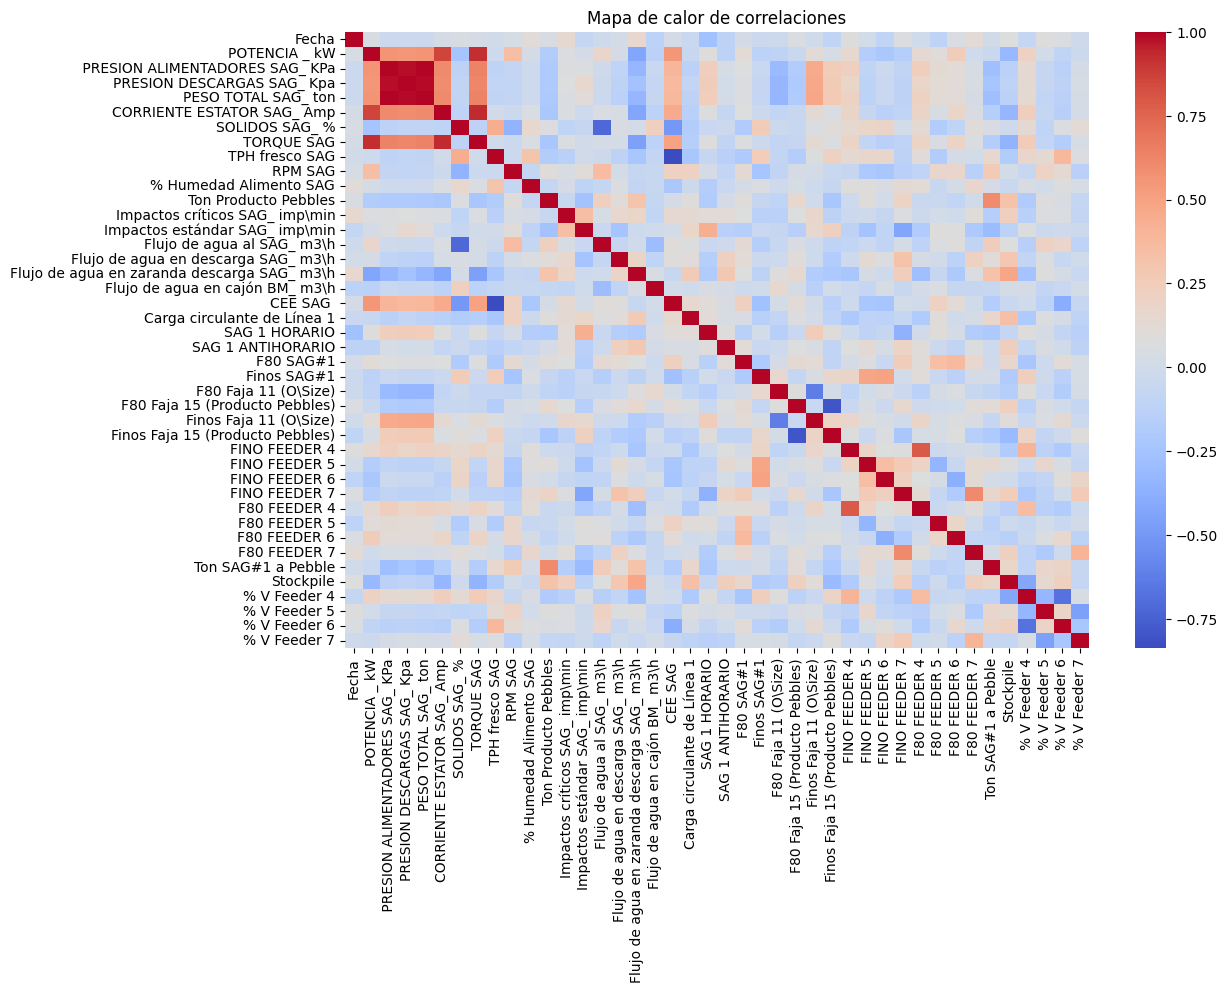

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_filtrado_pot.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()

In [ ]:
import pandas as pd

# Calcular matriz de correlaciones
corr = df_filtrado_pot.corr()

# Convertir a formato lista (pares de variables)
corr_pairs = (
    corr.abs()  # tomamos valor absoluto
    .unstack()  # convertimos a series
    .sort_values(ascending=False)  # ordenamos
)

# Eliminar duplicados y la diagonal (correlación de una variable consigo misma)
corr_pairs = corr_pairs.drop_duplicates()

# Mostrar las top 10 correlaciones más fuertes
corr_pairs.head(100) 

% V Feeder 7                                 % V Feeder 7                        1.000000
 PRESION ALIMENTADORES SAG_ KPa              PESO TOTAL SAG_ ton                 0.996126
PESO TOTAL SAG_ ton                          PRESION DESCARGAS SAG_ Kpa          0.992022
PRESION DESCARGAS SAG_ Kpa                    PRESION ALIMENTADORES SAG_ KPa     0.980922
TORQUE SAG                                   CORRIENTE ESTATOR SAG_ Amp          0.932267
                                                                                   ...   
 PRESION ALIMENTADORES SAG_ KPa              Finos Faja 15 (Producto Pebbles)    0.255851
Flujo de agua en zaranda descarga SAG_ m3\h  % V Feeder 4                        0.254949
% V Feeder 4                                 TORQUE SAG                          0.254727
Impactos estándar SAG_ imp\min               FINO FEEDER 5                       0.254469
FINO FEEDER 7                                Stockpile                           0.253465
Length: 10

In [33]:
corr_pairs.head(10)

% V Feeder 7                    % V Feeder 7                      1.0
Fecha                           Fecha                             1.0
CEE SAG                         CEE SAG                           1.0
Finos SAG#1                     Finos SAG#1                       1.0
F80 FEEDER 4                    F80 FEEDER 4                      1.0
% V Feeder 5                    % V Feeder 5                      1.0
Impactos estándar SAG_ imp\min  Impactos estándar SAG_ imp\min    1.0
TORQUE SAG                      TORQUE SAG                        1.0
F80 FEEDER 6                    F80 FEEDER 6                      1.0
SOLIDOS SAG_ %                  SOLIDOS SAG_ %                    1.0
dtype: float64

Correlación con 'TPH fresco SAG':
 TPH fresco SAG                                 1.000000
SOLIDOS SAG_ %                                 0.447323
% V Feeder 6                                   0.384139
% Humedad Alimento SAG                         0.309746
Finos SAG#1                                    0.251136
Finos Faja 15 (Producto Pebbles)               0.204810
FINO FEEDER 5                                  0.165612
FINO FEEDER 6                                  0.164150
% V Feeder 4                                   0.161529
Ton SAG#1 a Pebble                             0.158931
FINO FEEDER 4                                  0.135367
% V Feeder 5                                   0.134337
F80 FEEDER 4                                   0.106998
Finos Faja 11 (O\Size)                         0.073244
% V Feeder 7                                   0.066702
F80 FEEDER 6                                   0.022487
F80 FEEDER 7                                   0.005566
CORRIENTE EST

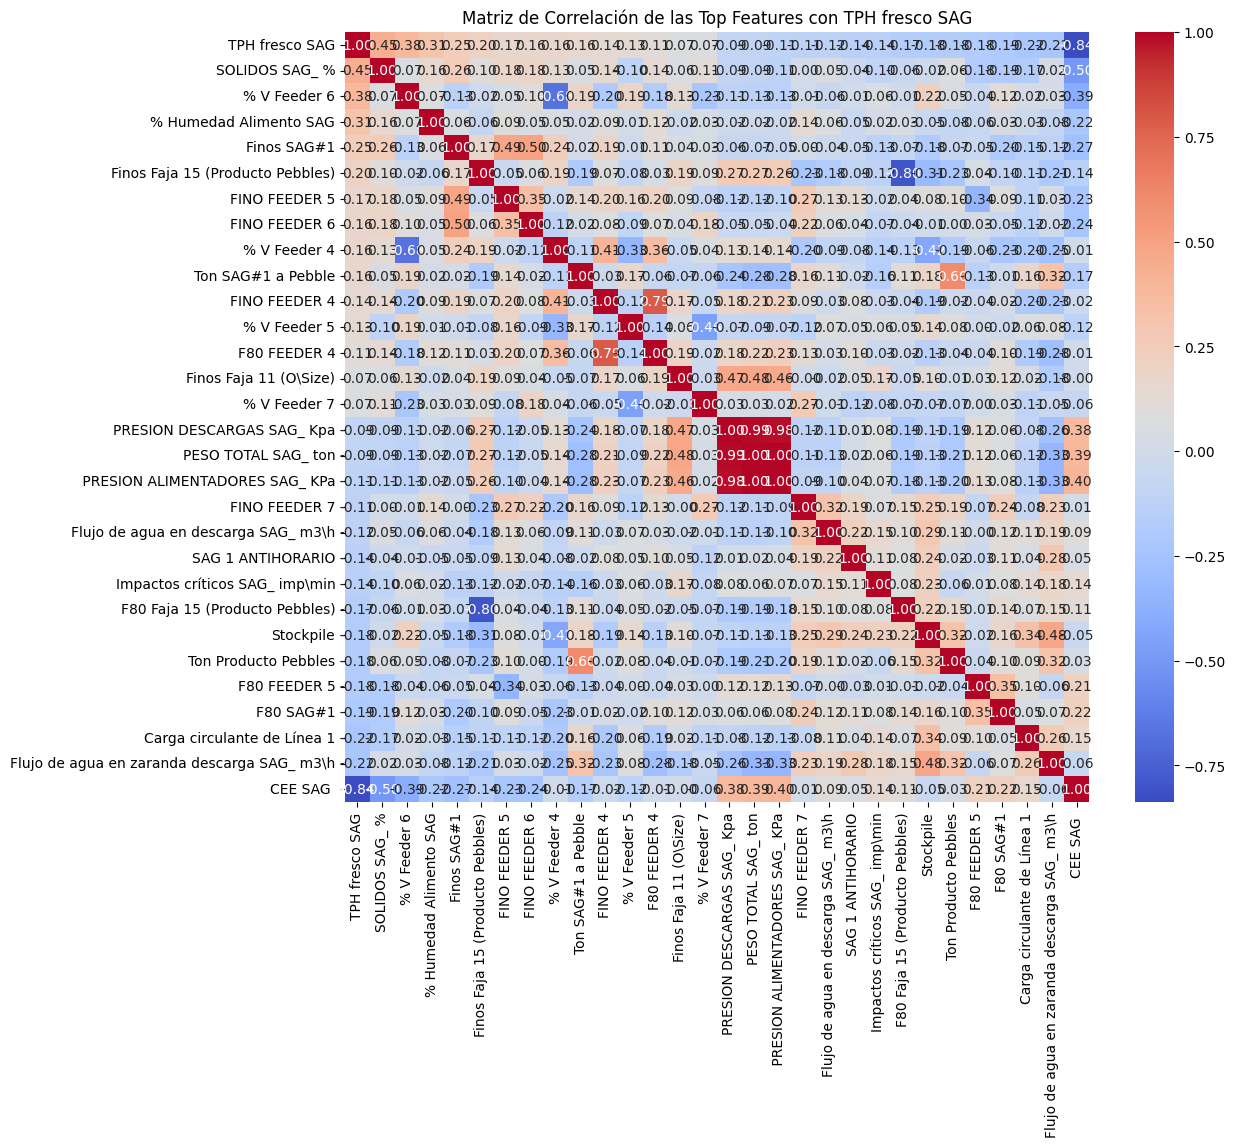

In [38]:
# Drop the 'Fecha' column as it's a datetime object and not suitable for correlation with numerical features.
df_numeric = df_filtrado_pot.drop(columns=['Fecha'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr(method='pearson')

# Get correlations with the target variable 'TPH fresco SAG'
tph_fresco_sag_corr = correlation_matrix['TPH fresco SAG'].sort_values(ascending=False)

print("Correlación con 'TPH fresco SAG':\n", tph_fresco_sag_corr)

# Optional: Visualize the top/bottom correlations with a heatmap
# For a large number of features, we might want to select only the most correlated ones.
# Let's consider plotting top N features for better readability.

# Filter for features with absolute correlation greater than a threshold (e.g., 0.5) or top N
# For now, let's just print all to allow user to decide further visualization needs.

# If you want to visualize specific highly correlated features:
top_n_features = 15 # You can adjust this number
top_correlated_features = tph_fresco_sag_corr.head(top_n_features).index.tolist() + \
                           tph_fresco_sag_corr.tail(top_n_features).index.tolist()
# Ensure 'TPH fresco SAG' is in the list for context
if 'TPH fresco SAG' not in top_correlated_features:
    top_correlated_features.append('TPH fresco SAG')

# Filter the original DataFrame for these features
df_top_corr = df_filtrado_pot[top_correlated_features]

plt.figure(figsize=(12, 10))
sns.heatmap(df_top_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de las Top Features con TPH fresco SAG')
plt.show()

In [23]:
df_filtrado_pot.describe()

,Fecha,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,...,F80 FEEDER 4,F80 FEEDER 5,F80 FEEDER 6,F80 FEEDER 7,Ton SAG#1 a Pebble,Stockpile,% V Feeder 4,% V Feeder 5,% V Feeder 6,% V Feeder 7
count,345022,484805.000000,484838.000000,484838.000000,484805.000000,480941.000000,484838.000000,463953.000000,484864.000000,484805.000000,...,484517.000000,483933.000000,484862.000000,484511.000000,484860.000000,484844.000000,484862.000000,484862.000000,484862.000000,484862.000000
mean,2019-09-01 17:23:53.018184448,21553.701702,7260.966838,7215.417913,3049.271879,3526.088888,74.831653,22486.871435,3379.383987,9.154453,...,2.911422,4.026320,5.055390,2.727719,613.994416,71.976726,12.117566,96.654461,83.613142,3.911763
min,2019-03-01 07:00:00,18189.047673,0.000000,0.000000,2638.242407,2687.086182,59.987210,18673.451839,2397.366172,7.249231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-06-02 14:49:15,20770.450563,7069.819458,7055.572142,2967.420239,3409.736802,72.996272,21747.785352,3263.793183,9.069560,...,0.000000,3.500000,4.500000,0.000000,528.800000,53.100000,0.100000,99.700000,78.000000,0.000000
50%,2019-09-04 11:18:30,21628.005664,7288.898741,7230.905807,3059.936934,3539.802686,75.271968,22599.683903,3432.980022,9.239951,...,3.600000,3.900000,5.000000,0.000000,616.700000,80.500000,3.900000,99.800000,91.200000,0.100000
75%,2019-11-13 22:30:45,22435.101449,7461.660334,7377.574442,3133.981539,3659.208496,76.995440,23336.598177,3538.754346,9.299621,...,4.400000,4.500000,5.600000,5.100000,710.600000,95.300000,16.100000,99.800000,97.900000,2.000000
max,2020-03-31 23:59:00,24685.323454,8201.756535,7940.068608,3429.996419,4050.138672,100.000000,25674.577067,4188.728849,9.304526,...,14.200000,14.700000,22.100000,36.000000,1176.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,1184.141633,289.727745,248.092711,120.493541,187.213200,2.629172,1171.132546,268.587881,0.193136,...,2.072678,0.963642,1.076215,3.434975,142.428436,26.179968,19.176044,9.588099,20.768961,9.738112


In [22]:
1-len(df_filtrado_pot)/len(df)

0.1513267520828957

In [14]:
df_filtrado_pot.columns

Index(['Fecha', 'POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa',
       'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton',
       'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG',
       'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG',
       'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\min',
       'Impactos estándar SAG_ imp\min', 'Flujo de agua al SAG_ m3\h',
       'Flujo de agua en descarga SAG_ m3\h',
       'Flujo de agua en zaranda descarga SAG_ m3\h',
       'Flujo de agua en cajón BM_ m3\h', 'CEE SAG ',
       'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO',
       'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\Size)',
       'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\Size)',
       'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5',
       'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5',
       'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile',
       '% V Feeder 4', '%

## creation features

In [ ]:
# Crear Features de Calendario y Codificación Cíclica desde la columna Fecha

# Obtener la columna de fecha
fecha_col = fecha_columns[0] if fecha_columns else None

if fecha_col:
    print("Creando features de calendario y codificación cíclica...")
    print("=" * 70)
    
    # 2a) Características de Calendario
    df_filtrado_pot['hour'] = df_filtrado_pot[fecha_col].dt.hour
    df_filtrado_pot['minute'] = df_filtrado_pot[fecha_col].dt.minute
    df_filtrado_pot['dayofweek'] = df_filtrado_pot[fecha_col].dt.dayofweek
    df_filtrado_pot['month'] = df_filtrado_pot[fecha_col].dt.month
    df_filtrado_pot['day'] = df_filtrado_pot[fecha_col].dt.day
    df_filtrado_pot['year'] = df_filtrado_pot[fecha_col].dt.year
    
    print("\n✓ Características de Calendario creadas:")
    print(f"  - hour: {df_filtrado_pot['hour'].min()}-{df_filtrado_pot['hour'].max()}")
    print(f"  - minute: {df_filtrado_pot['minute'].min()}-{df_filtrado_pot['minute'].max()}")
    print(f"  - dayofweek: {df_filtrado_pot['dayofweek'].min()}-{df_filtrado_pot['dayofweek'].max()}")
    print(f"  - month: {df_filtrado_pot['month'].min()}-{df_filtrado_pot['month'].max()}")
    
    # Para datos POR MINUTO
    df_filtrado_pot['time_in_day'] = (df_filtrado_pot['hour'] * 60) + df_filtrado_pot['minute']
    max_val_day = 1440  # 24 horas * 60 minutos

    df_filtrado_pot['day_sin'] = np.sin(2 * np.pi * df_filtrado_pot['time_in_day'] / max_val_day)
    df_filtrado_pot['day_cos'] = np.cos(2 * np.pi * df_filtrado_pot['time_in_day'] / max_val_day)
    
    print("\n✓ Codificación cíclica diaria creada:")
    print(f"  - time_in_day: {df_filtrado_pot['time_in_day'].min():.2f}-{df_filtrado_pot['time_in_day'].max():.2f}")
    print(f"  - day_sin: {df_filtrado_pot['day_sin'].min():.4f} a {df_filtrado_pot['day_sin'].max():.4f}")
    print(f"  - day_cos: {df_filtrado_pot['day_cos'].min():.4f} a {df_filtrado_pot['day_cos'].max():.4f}")
    
    # Codificación cíclica semanal
    max_val_week = 7  # 7 días de la semana
    df_filtrado_pot['week_sin'] = np.sin(2 * np.pi * df_filtrado_pot['dayofweek'] / max_val_week)
    df_filtrado_pot['week_cos'] = np.cos(2 * np.pi * df_filtrado_pot['dayofweek'] / max_val_week)
    
    print("\n✓ Codificación cíclica semanal creada:")
    print(f"  - week_sin: {df_filtrado_pot['week_sin'].min():.4f} a {df_filtrado_pot['week_sin'].max():.4f}")
    print(f"  - week_cos: {df_filtrado_pot['week_cos'].min():.4f} a {df_filtrado_pot['week_cos'].max():.4f}")
    
    print("\n" + "=" * 70)
    print("✓ Features creadas exitosamente")
    print("\nNuevas columnas agregadas:")
    new_cols = ['hour', 'minute', 'dayofweek', 'month', 'day', 'year', 
                'time_in_day', 'day_sin', 'day_cos', 'week_sin', 'week_cos']
    print(f"  {new_cols}")
    
    print(f"\nTotal de columnas en df_filtrado_pot: {len(df_filtrado_pot.columns)}")
    print("\nPrimeras filas con features:")
    print(df_filtrado_pot[['Fecha', 'hour', 'minute', 'dayofweek', 'day_sin', 'day_cos', 'week_sin', 'week_cos']].head(10))
    
else:
    print("❌ Error: No se encontró columna de fecha")
    print(f"Columnas disponibles: {list(df_filtrado_pot.columns)}")

Creando features de calendario y codificación cíclica...

✓ Características de Calendario creadas:
  - hour: 0.0-23.0
  - minute: 0.0-59.0
  - dayofweek: 0.0-6.0
  - month: 2.0-11.0

✓ Codificación cíclica diaria creada:
  - time_in_day: 0.00-1439.00
  - day_sin: -1.0000 a 1.0000
  - day_cos: -1.0000 a 1.0000

✓ Codificación cíclica semanal creada:
  - week_sin: -0.9749 a 0.9749
  - week_cos: -0.9010 a 1.0000

✓ Features creadas exitosamente

Nuevas columnas agregadas:
  ['hour', 'minute', 'dayofweek', 'month', 'day', 'year', 'time_in_day', 'day_sin', 'day_cos', 'week_sin', 'week_cos']

Total de columnas en df_filtrado_pot: 53

Primeras filas con features:
                Fecha  hour  minute  dayofweek   day_sin   day_cos  week_sin  \
0 2019-03-01 07:00:00   7.0     0.0        4.0  0.965926 -0.258819 -0.433884   
1 2019-03-01 07:01:00   7.0     1.0        4.0  0.964787 -0.263031 -0.433884   
2 2019-03-01 07:02:00   7.0     2.0        4.0  0.963630 -0.267238 -0.433884   
3 2019-03-01 07

In [ ]:
df_filtrado_pot

,Fecha,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,...,minute,dayofweek,month,day,year,time_in_day,day_sin,day_cos,week_sin,week_cos
0,2019-03-01 07:00:00,22851.059386,7442.802795,7326.981571,3123.465470,3745.792969,75.141449,23796.759043,3480.590445,9.169480,...,0.0,4.0,3.0,1.0,2019.0,420.0,0.965926,-0.258819,-0.433884,-0.900969
1,2019-03-01 07:01:00,22877.158502,7450.330352,7335.030702,3125.292839,3740.590332,74.515007,23821.758529,3495.946182,9.169887,...,1.0,4.0,3.0,1.0,2019.0,421.0,0.964787,-0.263031,-0.433884,-0.900969
2,2019-03-01 07:02:00,22911.347363,7448.179272,7330.731855,3125.954456,3742.448486,74.691086,23865.669466,3484.942773,9.169361,...,2.0,4.0,3.0,1.0,2019.0,422.0,0.963630,-0.267238,-0.433884,-0.900969
3,2019-03-01 07:03:00,22924.380371,7453.894749,7335.148482,3127.161898,3709.747070,75.124451,23876.142513,3496.260614,9.169222,...,3.0,4.0,3.0,1.0,2019.0,423.0,0.962455,-0.271440,-0.433884,-0.900969
4,2019-03-01 07:04:00,22873.107357,7461.798114,7337.060156,3130.050777,3729.627930,74.919861,23813.244124,3509.473818,9.170830,...,4.0,4.0,3.0,1.0,2019.0,424.0,0.961262,-0.275637,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571315,NaT,20830.061105,7554.161068,7475.295024,3179.508283,3388.194151,70.886111,21401.393750,2996.904041,9.299532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571316,NaT,20787.206154,7555.147470,7473.874118,3179.175749,3376.106199,71.157511,21348.188721,3001.949894,9.299710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571317,NaT,20781.620394,7553.500864,7471.669816,3178.493436,3379.115427,70.594137,21343.711605,2989.469403,9.299889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571318,NaT,20797.206673,7547.451255,7469.120616,3176.601584,3379.568235,71.066776,21360.320736,2960.067098,9.299869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ==================== FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS MEJORADA ====================

def crear_features_mejoradas(df, fecha_col='Fecha', target_col='TPH fresco SAG'):
    """
    Genera características cíclicas, rezagos y promedios/estándares móviles para series por MINUTO.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        Dataframe con datos por minuto
    fecha_col : str
        Nombre de la columna datetime
    target_col : str
        Nombre de la columna objetivo/variable principal
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame con features ingenieros y datos limpios (sin NaN)
    """
    
    print("Creando features mejoradas para datos por minuto...")
    print("=" * 70)
    
    # Hacer una copia para no modificar el original
    df = df.copy()
    
    # Establecer índice como datetime
    if fecha_col in df.columns:
        df[fecha_col] = pd.to_datetime(df[fecha_col])
        df = df.set_index(fecha_col)
        print(f"\n✓ Índice establecido como: {fecha_col}")
    
    # 2a) Características de Calendario
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['year'] = df.index.year
    print("\n✓ Características de Calendario creadas:")
    print(f"  - hour, minute, dayofweek, month, day, year")
    
    # 2b) Codificación Cíclica para datos POR MINUTO
    df['time_in_day'] = (df['hour'] * 60) + df['minute']  # 0 a 1439 minutos
    max_val_day = 1440  # 24 horas * 60 minutos
    df['day_sin'] = np.sin(2 * np.pi * df['time_in_day'] / max_val_day)
    df['day_cos'] = np.cos(2 * np.pi * df['time_in_day'] / max_val_day)
    print("\n✓ Codificación Cíclica Diaria creada (1440 intervalos):")
    print(f"  - time_in_day: 0-1439 minutos")
    print(f"  - day_sin, day_cos")
    
    # Codificación cíclica semanal
    max_val_week = 7
    df['week_sin'] = np.sin(2 * np.pi * df['dayofweek'] / max_val_week)
    df['week_cos'] = np.cos(2 * np.pi * df['dayofweek'] / max_val_week)
    print("\n✓ Codificación Cíclica Semanal creada:")
    print(f"  - week_sin, week_cos")
    
    # 2c) Rezagos (Lags) - Para datos por minuto
    # 1 minuto, 1 hora (60 min), 1 día (1440 min), 1 semana (10080 min)
    lag_values = [1, 60, 1440, 10080]
    lag_names = ['1min', '1h', '1day', '1week']
    
    print("\n✓ Creando Rezagos (Lags):")
    for lag, name in zip(lag_values, lag_names):
        if lag < len(df):  # Verificar que el lag sea válido
            df[f"{target_col.replace(' ', '_')}_lag_{name}"] = df[target_col].shift(lag)
            print(f"  - lag_{name} ({lag} minutos)")
    
    # 2d) Promedios y Estándares Móviles
    # 1 hora (60 min), 1 día (1440 min), 1 semana (10080 min)
    windows = [60, 1440, 10080]
    window_names = ['1h', '1day', '1week']
    
    print("\n✓ Creando Medias y Estándares Móviles:")
    for window, name in zip(windows, window_names):
        if window < len(df):  # Verificar que la ventana sea válida
            df[f"{target_col.replace(' ', '_')}_roll_mean_{name}"] = df[target_col].shift(1).rolling(window).mean()
            df[f"{target_col.replace(' ', '_')}_roll_std_{name}"] = df[target_col].shift(1).rolling(window).std()
            print(f"  - roll_mean_{name} ({window} minutos)")
            print(f"  - roll_std_{name} ({window} minutos)")
    
    # 2e) Limpieza de columnas auxiliares no necesarias
    cols_to_drop = ['hour', 'minute', 'dayofweek', 'time_in_day', 'month', 'day', 'year']
    existing_cols = [col for col in cols_to_drop if col in df.columns]
    
    if existing_cols:
        df.drop(columns=existing_cols, inplace=True)
        print(f"\n✓ Columnas auxiliares eliminadas: {existing_cols}")
    
    # Remover NaN generados por lags y rolling windows
    initial_rows = len(df)
    df = df.dropna()
    final_rows = len(df)
    removed_rows = initial_rows - final_rows
    
    print("\n" + "=" * 70)
    print("RESUMEN DE FEATURES CREADAS:")
    print("=" * 70)
    print(f"Filas iniciales:  {initial_rows:,}")
    print(f"Filas finales:    {final_rows:,}")
    print(f"Filas removidas:  {removed_rows:,} ({removed_rows/initial_rows*100:.2f}%)")
    print(f"\nTotal de columnas: {len(df.columns)}")
    print(f"Nuevas columnas de features:\n{[col for col in df.columns if col not in ['Fecha']]}")
    
    return df

# Aplicar la función
print("\nAPLICANDO FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS")
print("=" * 70)
df_features = crear_features_mejoradas(df_filtrado_pot, 
                                       fecha_col='Fecha', 
                                       target_col='TPH fresco SAG')

print("\n✓ Dataframe con features listo")
print(f"\nPrimeras filas:")
print(df_features.head())


APLICANDO FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS
Creando features mejoradas para datos por minuto...

✓ Índice establecido como: Fecha

✓ Características de Calendario creadas:
  - hour, minute, dayofweek, month, day, year

✓ Codificación Cíclica Diaria creada (1440 intervalos):
  - time_in_day: 0-1439 minutos
  - day_sin, day_cos

✓ Codificación Cíclica Semanal creada:
  - week_sin, week_cos

✓ Creando Rezagos (Lags):
  - lag_1min (1 minutos)
  - lag_1h (60 minutos)
  - lag_1day (1440 minutos)
  - lag_1week (10080 minutos)

✓ Creando Medias y Estándares Móviles:
  - roll_mean_1h (60 minutos)
  - roll_std_1h (60 minutos)
  - roll_mean_1day (1440 minutos)
  - roll_std_1day (1440 minutos)
  - roll_mean_1week (10080 minutos)
  - roll_std_1week (10080 minutos)

✓ Columnas auxiliares eliminadas: ['hour', 'minute', 'dayofweek', 'time_in_day', 'month', 'day', 'year']

RESUMEN DE FEATURES CREADAS:
Filas iniciales:  484,864
Filas finales:    270,835
Filas removidas:  214,029 (44.14%)

Total 

In [ ]:
df_features

,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,% Humedad Alimento SAG,...,TPH_fresco_SAG_lag_1min,TPH_fresco_SAG_lag_1h,TPH_fresco_SAG_lag_1day,TPH_fresco_SAG_lag_1week,TPH_fresco_SAG_roll_mean_1h,TPH_fresco_SAG_roll_std_1h,TPH_fresco_SAG_roll_mean_1day,TPH_fresco_SAG_roll_std_1day,TPH_fresco_SAG_roll_mean_1week,TPH_fresco_SAG_roll_std_1week
Fecha,,,,,,,,,,,,,,,,,,,,,
2019-03-08 07:32:00,19120.336230,6846.899943,6839.927127,2867.571549,3251.184814,77.099930,20741.828825,3014.391967,8.799627,2.037363,...,2998.812902,3421.468174,3454.088369,3480.590445,3278.599162,209.801966,3446.642557,68.837111,3331.462672,196.630377
2019-03-08 07:33:00,19103.585270,6838.055750,6830.465325,2863.408634,3234.462402,77.102264,20729.256755,2995.924599,8.799459,2.039464,...,3014.391967,3432.462128,3445.399967,3495.946182,3271.814559,211.677203,3446.337213,69.772893,3331.416422,196.650123
2019-03-08 07:34:00,19102.478317,6827.598767,6823.049171,2860.187797,3233.905029,77.073685,20730.006673,2993.073319,8.799816,1.956385,...,2995.924599,3430.724530,3452.984809,3484.942773,3264.538933,213.555796,3446.025077,70.775274,3331.366817,196.671681
2019-03-08 07:35:00,19086.532718,6823.492314,6817.147308,2857.737732,3237.222900,77.116066,20708.021061,2999.433051,8.799667,1.985380,...,2993.073319,3444.237748,3448.906766,3496.260614,3257.244746,215.250828,3445.705694,71.774498,3331.318020,196.694591
2019-03-08 07:36:00,19099.055900,6819.352922,6814.670318,2855.065942,3233.719238,77.253662,20719.103646,2998.457638,8.799459,2.045766,...,2999.433051,3457.633657,3452.973760,3509.473818,3249.831335,216.358349,3445.393559,72.731528,3331.268732,196.715502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 23:55:00,20793.775132,7528.731009,7446.034639,3167.243385,3401.490232,71.373497,21358.935004,2521.372164,9.299879,2.942419,...,2476.525077,2497.858877,3196.107033,3403.735913,2500.474037,18.705426,2918.710702,359.170371,3152.529931,270.357274
2020-03-31 23:56:00,20843.029003,7521.849493,7437.622644,3163.649214,3409.301406,73.061862,21398.162473,2627.496057,9.299661,2.889241,...,2521.372164,2517.123031,3240.638416,3400.574028,2500.865925,18.895055,2918.242136,359.248349,3152.442395,270.418769
2020-03-31 23:57:00,20835.055018,7524.052772,7440.332349,3164.165374,3410.237264,73.692534,21394.098617,2725.415369,9.299879,2.964897,...,2627.496057,2530.317367,3222.000354,3429.741699,2502.705476,24.917567,2917.816343,359.229326,3152.365701,270.458013


## entrenamiento

In [ ]:
# ==================== ENTRENAMIENTO DEL MODELO ====================

print("ENTRENAMIENTO DEL MODELO DE PREDICCIÓN")
print("=" * 70)

# Importar métricas necesarias
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Los features ya fueron creados en la celda anterior
print(f"\n✓ Dataframe con features: {df_features.shape}")
print(f"  Filas: {df_features.shape[0]:,}")
print(f"  Columnas: {df_features.shape[1]}")

# Definir variable objetivo
target_col = 'TPH fresco SAG'

# Verificar que la columna existe
if target_col in df_features.columns:
    print(f"\n✓ Variable objetivo: {target_col}")
    
    # Definir X (features) e y (target)
    X = df_features.drop(columns=[target_col,'TPH_fresco_SAG_lag_1min'])
    y = df_features[target_col]
    
    print(f"✓ X shape: {X.shape}")
    print(f"✓ y shape: {y.shape}")
    
    # Separar en train/test (shuffle=False es CRÍTICO para series de tiempo)
    print("\n" + "=" * 70)
    print("DIVISIÓN TRAIN/TEST (sin shuffle - preserva orden temporal)")
    print("=" * 70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    print(f"\n✓ Conjunto de entrenamiento:")
    print(f"  - X_train shape: {X_train.shape}")
    print(f"  - y_train shape: {y_train.shape}")
    print(f"\n✓ Conjunto de prueba:")
    print(f"  - X_test shape: {X_test.shape}")
    print(f"  - y_test shape: {y_test.shape}")
    
    # Entrenar el modelo
    print("\n" + "=" * 70)
    print("ENTRENAMIENTO DEL MODELO")
    print("=" * 70)
    print("\nConfigurando RandomForestRegressor...")
    print("  - n_estimators: 300 (300 árboles)")
    print("  - max_depth: 15 (profundidad máxima)")
    print("  - random_state: 42 (reproducibilidad)")
    print("  - n_jobs: -1 (usar todos los cores)")
    
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    print("\nEntrenando el modelo...")
    import time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"✓ Modelo entrenado en {training_time:.2f} segundos")
    
    # Realizar predicciones
    print("\n" + "=" * 70)
    print("EVALUACIÓN DEL MODELO")
    print("=" * 70)
    
    print("\nRealizando predicciones en conjunto de prueba...")
    y_pred = model.predict(X_test)
    print(f"✓ Predicciones realizadas: {len(y_pred)}")
    
    # Calcular métricas
    print("\nCalculando métricas de desempeño...")
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print("\n" + "=" * 70)
    print("RESULTADOS DEL MODELO")
    print("=" * 70)
    print(f"\n📊 MÉTRICAS DE DESEMPEÑO:")
    print(f"  - R² Score:           {r2:.4f}")
    print(f"  - MAE (Error Absoluto Medio): {mae:.4f}")
    print(f"  - RMSE (Error Cuadrático Medio): {rmse:.4f}")
    print(f"  - MAPE (Error Porcentual):    {mape:.4f}%")
    
    print(f"\n📈 ESTADÍSTICAS DE PREDICCIÓN:")
    print(f"  - y_test (min, max):  {y_test.min():.4f}, {y_test.max():.4f}")
    print(f"  - y_pred (min, max):  {y_pred.min():.4f}, {y_pred.max():.4f}")
    print(f"  - Diferencia promedio: {(y_pred - y_test).mean():.4f}")
    
    # Importancia de features
    print(f"\n🎯 TOP 10 FEATURES MÁS IMPORTANTES:")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    # Guardar métricas en diccionario
    metricas_modelo = {
        'Modelo': 'RandomForestRegressor',
        'R²': f"{r2:.4f}",
        'MAE': f"{mae:.4f}",
        'RMSE': f"{rmse:.4f}",
        'MAPE': f"{mape:.4f}%",
        'Registros_Train': len(X_train),
        'Registros_Test': len(X_test),
        'Tiempo_Entrenamiento_seg': f"{training_time:.2f}"
    }
    
    print("\n" + "=" * 70)
    print("✓ Modelo entrenado y evaluado exitosamente")
    print("=" * 70)
    
else:
    print(f"❌ Error: La columna '{target_col}' no existe en df_features")
    print(f"Columnas disponibles: {list(df_features.columns)}")

ENTRENAMIENTO DEL MODELO DE PREDICCIÓN

✓ Dataframe con features: (270835, 55)
  Filas: 270,835
  Columnas: 55

✓ Variable objetivo: TPH fresco SAG
✓ X shape: (270835, 53)
✓ y shape: (270835,)

DIVISIÓN TRAIN/TEST (sin shuffle - preserva orden temporal)

✓ Conjunto de entrenamiento:
  - X_train shape: (216668, 53)
  - y_train shape: (216668,)

✓ Conjunto de prueba:
  - X_test shape: (54167, 53)
  - y_test shape: (54167,)

ENTRENAMIENTO DEL MODELO

Configurando RandomForestRegressor...
  - n_estimators: 300 (300 árboles)
  - max_depth: 15 (profundidad máxima)
  - random_state: 42 (reproducibilidad)
  - n_jobs: -1 (usar todos los cores)

Entrenando el modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.0s finished


✓ Modelo entrenado en 163.98 segundos

EVALUACIÓN DEL MODELO

Realizando predicciones en conjunto de prueba...
✓ Predicciones realizadas: 54167

Calculando métricas de desempeño...

RESULTADOS DEL MODELO

📊 MÉTRICAS DE DESEMPEÑO:
  - R² Score:           0.9763
  - MAE (Error Absoluto Medio): 23.9576
  - RMSE (Error Cuadrático Medio): 41.9121
  - MAPE (Error Porcentual):    0.6862%

📈 ESTADÍSTICAS DE PREDICCIÓN:
  - y_test (min, max):  2397.5823, 4133.9162
  - y_pred (min, max):  2409.3431, 4029.6665
  - Diferencia promedio: -0.1644

🎯 TOP 10 FEATURES MÁS IMPORTANTES:
                    feature  importance
                   CEE SAG     0.652794
TPH_fresco_SAG_roll_mean_1h    0.248863
              POTENCIA _ kW    0.058399
               % V Feeder 6    0.013835
 TPH_fresco_SAG_roll_std_1h    0.008392
      TPH_fresco_SAG_lag_1h    0.001907
               % V Feeder 5    0.001477
                 TORQUE SAG    0.001391
               % V Feeder 4    0.001272
       Ton Producto Pebble

VISUALIZACIÓN DE PREDICCIONES

✓ Longitud de y_test: 54,167 puntos
✓ Longitud de y_pred: 54,167 puntos

Mostrando últimas 12 horas (60 minutos)...
✓ Datos filtrados a últimas 12 horas (60 puntos)


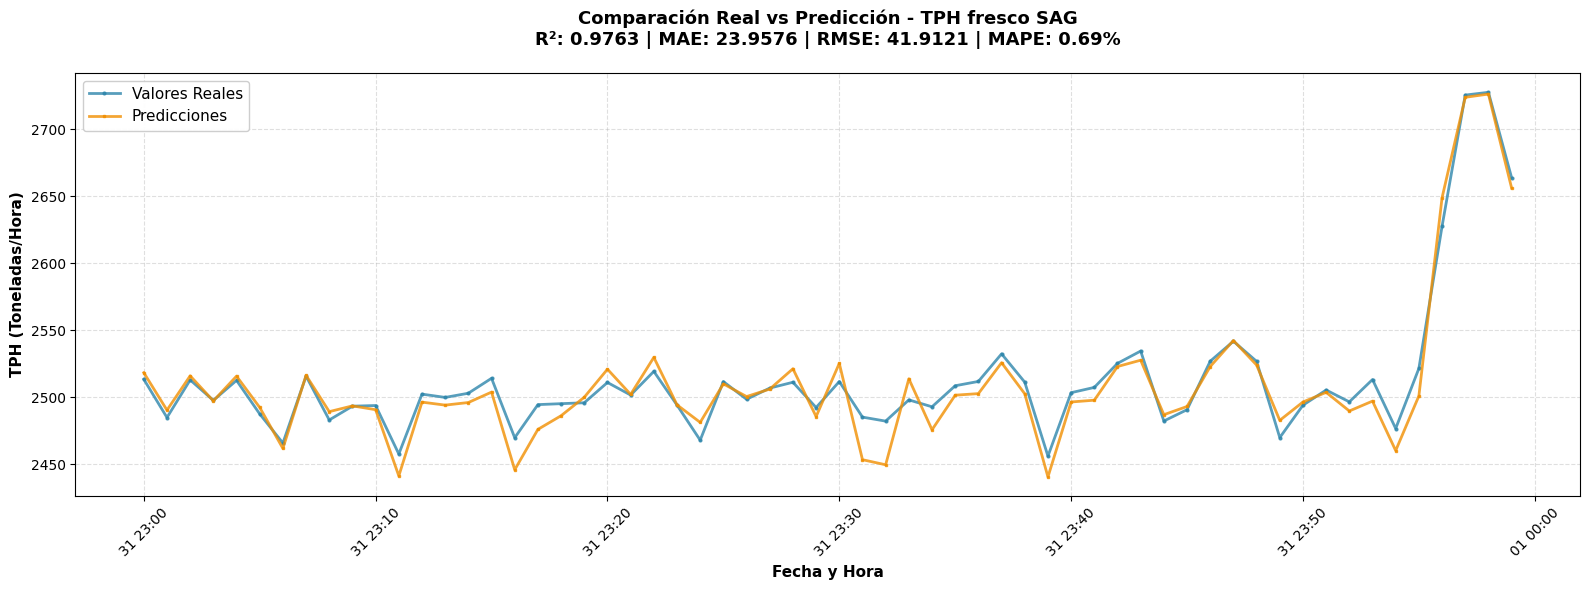


✓ Gráfica generada exitosamente

ANÁLISIS DE ERRORES

📊 Estadísticas de Error Absoluto:
  - Error mínimo:  0.1770
  - Error máximo:  32.5906
  - Error promedio: 8.3204
  - Error mediana:  6.6808
  - Desv. Estándar: 7.3878

🎯 Precisión:
  - Predicciones dentro de ±11.98:  75.00%
  - Predicciones dentro de ±23.96:  96.67%


In [ ]:
# ==================== VISUALIZACIÓN DE PREDICCIONES ====================

print("VISUALIZACIÓN DE PREDICCIONES")
print("=" * 70)

# Crear serie de predicciones con el mismo índice que y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Ordenar por índice (fecha)
y_pred_series = y_pred_series.sort_index()
y_test = y_test.sort_index()

print(f"\n✓ Longitud de y_test: {len(y_test):,} puntos")
print(f"✓ Longitud de y_pred: {len(y_pred_series):,} puntos")

# Calcular horas a mostrar (últimas 12 horas en minutos)
# Para datos por minuto: 1 hora = 60 minutos, 12 horas = 720 puntos
horas_a_mostrar = 1 * 60  # 720 puntos (12 horas)

print(f"\nMostrando últimas 12 horas ({horas_a_mostrar:,} minutos)...")

# Filtrar el último segmento
if len(y_test) > horas_a_mostrar:
    y_test_zoom = y_test.iloc[-horas_a_mostrar:]
    y_pred_zoom = y_pred_series.iloc[-horas_a_mostrar:]
    print(f"✓ Datos filtrados a últimas 12 horas ({horas_a_mostrar:,} puntos)")
else:
    y_test_zoom = y_test
    y_pred_zoom = y_pred_series
    print(f"⚠️  Dataset menor a 12 horas, mostrando todo ({len(y_test):,} puntos)")

# Crear figura
fig, ax = plt.subplots(figsize=(16, 6))

# Plotear valores reales
ax.plot(y_test_zoom.index, y_test_zoom.values, 
        label='Valores Reales', color='#2E86AB', linewidth=2, alpha=0.8, marker='o', markersize=2)

# Plotear predicciones
ax.plot(y_pred_zoom.index, y_pred_zoom.values, 
        label='Predicciones', color='#F18F01', linewidth=2, alpha=0.8, marker='s', markersize=2)

# Título con métricas
titulo = f"Comparación Real vs Predicción - {target_col}\nR²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%"
ax.set_title(titulo, fontsize=13, fontweight='bold', pad=20)

# Etiquetas y estilos
ax.set_xlabel('Fecha y Hora', fontsize=11, fontweight='bold')
ax.set_ylabel('TPH (Toneladas/Hora)', fontsize=11, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, linestyle='--', alpha=0.4)

# Rotar etiquetas del eje X
ax.tick_params(axis='x', rotation=45)

# Ajustar layout
plt.tight_layout()
plt.show()

print("\n✓ Gráfica generada exitosamente")

# Calcular y mostrar error por punto
print("\n" + "=" * 70)
print("ANÁLISIS DE ERRORES")
print("=" * 70)

errores = np.abs(y_test_zoom.values - y_pred_zoom.values)
print(f"\n📊 Estadísticas de Error Absoluto:")
print(f"  - Error mínimo:  {errores.min():.4f}")
print(f"  - Error máximo:  {errores.max():.4f}")
print(f"  - Error promedio: {errores.mean():.4f}")
print(f"  - Error mediana:  {np.median(errores):.4f}")
print(f"  - Desv. Estándar: {errores.std():.4f}")

# Porcentaje de predicciones dentro de rangos de error
dentro_5pct = np.sum(errores <= mae * 0.5) / len(errores) * 100
dentro_10pct = np.sum(errores <= mae) / len(errores) * 100

print(f"\n🎯 Precisión:")
print(f"  - Predicciones dentro de ±{mae*0.5:.2f}:  {dentro_5pct:.2f}%")
print(f"  - Predicciones dentro de ±{mae:.2f}:  {dentro_10pct:.2f}%")


Total de variables numéricas: 55
Variables: ['POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa', 'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton', 'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG', 'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG', 'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\\min', 'Impactos estándar SAG_ imp\\min', 'Flujo de agua al SAG_ m3\\h', 'Flujo de agua en descarga SAG_ m3\\h', 'Flujo de agua en zaranda descarga SAG_ m3\\h', 'Flujo de agua en cajón BM_ m3\\h', 'CEE SAG ', 'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO', 'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\\Size)', 'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\\Size)', 'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5', 'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5', 'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile', '% V Feeder 4', '% V Feeder 5', '% V Feeder 6', '% V Feeder 7', 'day_sin', 'day_cos', 

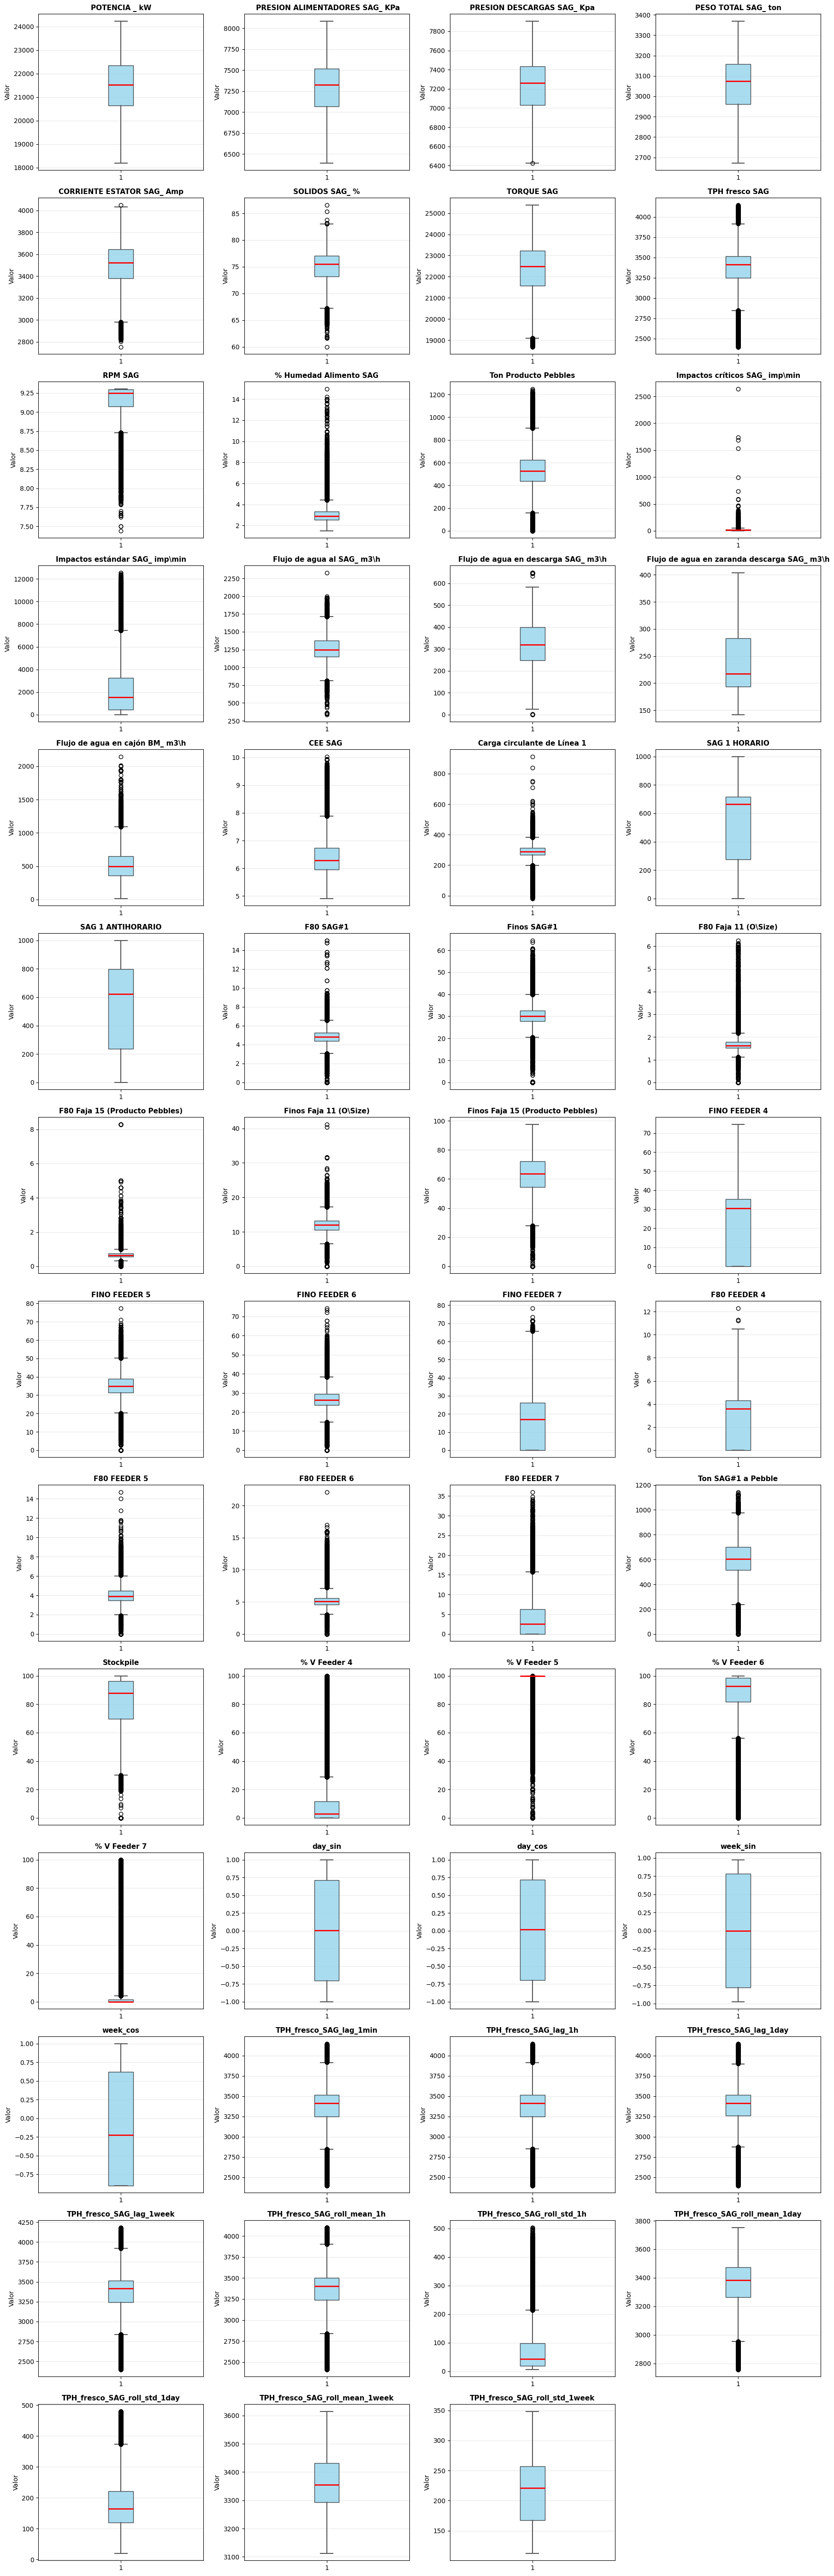


Estadísticas resumidas por variable:
                                                count          mean  \
POTENCIA _ kW                                270835.0  21427.804114   
 PRESION ALIMENTADORES SAG_ KPa              270835.0   7277.131397   
PRESION DESCARGAS SAG_ Kpa                   270835.0   7232.004385   
PESO TOTAL SAG_ ton                          270835.0   3056.391688   
CORRIENTE ESTATOR SAG_ Amp                   270835.0   3503.112807   
SOLIDOS SAG_ %                               270835.0     74.982107   
TORQUE SAG                                   270835.0  22341.355945   
TPH fresco SAG                               270835.0   3357.252187   
RPM SAG                                      270835.0      9.159305   
% Humedad Alimento SAG                       270835.0      2.996554   
Ton Producto Pebbles                         270835.0    530.541730   
Impactos críticos SAG_ imp\min               270835.0     17.800435   
Impactos estándar SAG_ imp\min         

In [ ]:


# Boxplots para todas las variables numéricas (excepto fecha)

# Obtener columnas numéricas (excluyendo datetime)
columnas_numericas = df_features.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total de variables numéricas: {len(columnas_numericas)}")
print(f"Variables: {columnas_numericas}\n")

# Crear subplots
n_cols = 4  # 4 gráficos por fila
n_rows = (len(columnas_numericas) + n_cols - 1) // n_cols  # Calcular filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()  # Convertir a array 1D

# Crear un boxplot para cada columna numérica
for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    # Boxplot
    bp = ax.boxplot(df_features[col].dropna(), vert=True, patch_artist=True)
    
    # Estilo
    for patch in bp['boxes']:
        patch.set_facecolor('#87CEEB')
        patch.set_alpha(0.7)
    
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, color='#555')
    
    for cap in bp['caps']:
        cap.set(linewidth=1.5, color='#555')
    
    for median in bp['medians']:
        median.set(linewidth=2, color='red')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Eliminar subplots vacíos
for idx in range(len(columnas_numericas), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Estadísticas resumidas por variable:")
print("="*70)
print(df_features[columnas_numericas].describe().T)